In [ ]:
################################################################################
########################          Yelp Reviews          ######################## 
########################    Classification : Catboost   ######################## 
########################       Polarity on Reviews      ########################
########################       Negative vs Positive     ########################
################################################################################

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gensim==3.8.3
!pip install catboost
!pip install optuna
import os
import random
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta
from timeit import default_timer as timer
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim import models
import multiprocessing
import pickle
import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
import optuna
from optuna import Trial
optuna.logging.set_verbosity(optuna.logging.WARNING) # use INFO to see progress
import joblib
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import plotly.offline as py
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

my_dpi=96

     |████████████████████████████████| 24.2 MB 691 kB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 76.6 MB 1.1 MB/s 
     |████████████████████████████████| 308 kB 4.2 MB/s 
     |████████████████████████████████| 81 kB 11.8 MB/s 
     |████████████████████████████████| 210 kB 75.7 MB/s 
     |████████████████████████████████| 78 kB 9.4 MB/s 
     |████████████████████████████████| 113 kB 74.1 MB/s 
     |████████████████████████████████| 146 kB 71.0 MB/s 
     |████████████████████████████████| 49 kB 8.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=d74567b6153e8184e078795f846136e052daabc252560fd3c7e9ba03754e2a53
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
print('CUDA and NVIDIA GPU Information')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

print('\n')
cores = multiprocessing.cpu_count()
print('Number of cores:', cores)

CUDA and NVIDIA GPU Information
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Wed Apr 20 13:10:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|            

In [ ]:
# Set seed 
seed_value = 42
os.environ['YelpReviews_ML'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/

/content/drive/MyDrive/Yelp_Reviews/Data


In [ ]:
# Read tokenized reviews with stars filtered to 1, 2 and 5
df = pd.read_parquet('YelpReviews_NLP_sentimentNegPos_tokenized.parquet')
print('Number of rows and columns:', df.shape)
df.head()

Number of rows and columns: (829874, 3)


,cleanReview,sentiment,stars_reviews
index,,,
1,"[order, chicken, finger, sub, honey, mustard, ...",Negative,3.0
3,"[dedicated, loving, memory, gary, feldman, gre...",Negative,5.0
12,"[absolutely, horrible, thought, would, order, ...",Negative,1.0
15,"[found, better, chicken, finger, know, inside,...",Negative,4.0
20,"[amazing, everything, tried, disappoint, chick...",Negative,5.0


In [ ]:
# Examine how star reviews pairs with sentiment polarity
print(df[['stars_reviews', 'sentiment']].value_counts())

stars_reviews  sentiment
5.0            Positive     278011
1.0            Negative     231245
4.0            Positive     104585
2.0            Negative      90320
3.0            Negative      44097
4.0            Negative      26276
5.0            Negative      22999
3.0            Positive      22096
2.0            Positive       6690
1.0            Positive       3555
dtype: int64


In [ ]:
# Process format of reviews for word2vec
df = df.copy()
df["cleanReview"]= [[f'"{j}"' for j in i] for i in df["cleanReview"]]
df.head()

,cleanReview,sentiment,stars_reviews
index,,,
1,"[""order"", ""chicken"", ""finger"", ""sub"", ""honey"",...",Negative,3.0
3,"[""dedicated"", ""loving"", ""memory"", ""gary"", ""fel...",Negative,5.0
12,"[""absolutely"", ""horrible"", ""thought"", ""would"",...",Negative,1.0
15,"[""found"", ""better"", ""chicken"", ""finger"", ""know...",Negative,4.0
20,"[""amazing"", ""everything"", ""tried"", ""disappoint...",Negative,5.0


In [ ]:
# Recode to binary
df = df.copy()
df['sentiment'].mask(df['sentiment'] == 'Negative', 0, inplace=True)
df['sentiment'].mask(df['sentiment'] == 'Positive', 1, inplace=True)

print('Number of reviews per group:')
df[['sentiment']].value_counts() 

Number of reviews per group:


sentiment
0            414937
1            414937
dtype: int64

In [ ]:
df = df.copy()
df['sentiment'] = df['sentiment'].astype('int')
df.dtypes

cleanReview       object
sentiment          int64
stars_reviews    float64
dtype: object

In [ ]:
# Set up label and features
label = df[['sentiment']]
features = df.cleanReview

In [ ]:
# Define parameters for Word2Vec model
base_model = Word2Vec(min_count=1, window=5, size=20, workers=cores)

In [ ]:
# Build vocab for model
print('Time to build vocab:', end=' ')
start = time.time()
base_model.build_vocab(features)
end = time.time()
print(round(end-start,2), 'seconds')

Time to build vocab: 41.44 seconds


In [ ]:
total_examples = base_model.corpus_count

In [ ]:
# Set path
%cd /content/drive/MyDrive/Yelp_Reviews/Data/preTrainedModel/

/content/drive/MyDrive/Yelp_Reviews/Data/preTrainedModel


In [ ]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = ('glove.6B.50d.txt')
tmp_file = get_tmpfile("test_word2vec.txt")

_ = glove2word2vec(glove_file, tmp_file) 
#After that, I could import my vectors with 
glove_vector = KeyedVectors.load_word2vec_format(tmp_file)

In [ ]:
base_model.build_vocab([list(glove_vector.vocab.keys())], update=True)

In [ ]:
# train on your data
# Generate Word2Vec Word Embeddings
print('Time to train model:', end=' ')
start = time.time()
base_model.train(features, total_examples=total_examples, epochs=50) 
end = time.time()
print(round(end-start,2), 'seconds')
base_model_wv = base_model.wv

Time to train model: 1199.53 seconds


In [ ]:
glove = base_model
glove_wv = base_model.wv

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models/

/content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models


In [ ]:
#Saving the model
wv = glove_wv
glove.wv.save_word2vec_format('glove.6B.50dModel_sentPoSNeg_50epochs.bin', 
                              binary=True)

# Load model
#word2vec_path = 'glove.6B.50dModel_sentPoSNeg_50epochs.bin'
#model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
#wv = model.wv

In [ ]:
# Creating Mean Word Embeddings using Mean Embedding Vectorizer class
class W2vVectorizer(object):
    """
    This class is used to provide mean word vectors for review documents. 
    This is done in the transform function which is used to generate mean vectors in model pipelines.
    The class has both fit and transform functions so that it may be used in an sklearn Pipeline.
    """
    
    def __init__(self, w2v):
        self.w2v = w2v
        
        #If using GloVe the model is in a dictionary format
        if isinstance(w2v, dict):
            if len(w2v) == 0:
                self.dimensions = 0
            else:
                self.dimensions = len(w2v[next(iter(w2v))])
        #Otherwise, using gensim keyed vector
        else:
            self.dimensions = w2v.vector_size
    
    # Need to implement a fit method as required for sklearn Pipeline.
    def fit(self, X, y):
        return self

    def transform(self, X):
        """
        This function generates a w2v vector for a set of tokens. This is done by taking 
        the mean of each token in the review.
        """
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                    or [np.zeros(self.dimensions)], axis=0) for words in X])

In [ ]:
print('Pipeline for Word2Vec of GloVe:')
pl  = Pipeline([("W2vVectorizer", W2vVectorizer(wv))])
pl

Pipeline for Word2Vec of GloVe:


Pipeline(steps=[('W2vVectorizer',
                 <__main__.W2vVectorizer object at 0x7f2b8e6795d0>)])

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/SentimentPolarity/Model_PKL/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/SentimentPolarity/Model_PKL


In [ ]:
def train_model_for_study(features, label, model):
    X_train, X_test, y_train, y_test = train_test_split(
        features, 
        label, 
        test_size=0.2, 
        stratify=label,
        random_state=seed_value
    )

    X_train = pl.fit_transform(X_train)
    X_test = pl.fit_transform(X_test)
    
    # Start timer for each trial
    start = timer()

    model.fit(
        X_train, 
        y_train.values.ravel(),
        eval_set=[(X_test, y_test.values.ravel())])

    # Predictions
    y_pred_val = model.predict_proba(X_test)
    cv_scores = log_loss(y_test, y_pred_val)     
    print('- Validation logloss:', np.mean(cv_scores))  
    run_time = timer() - start

    return np.mean(cv_scores)       

In [ ]:
################################################################################
######################    Catboost Optuna HPO    ###############################
######################  GloVe pretrained model   ###############################
######################         100 trials        ###############################
################################################################################
def cat_hpo(trial):
    """
    Objective function to tune a `CatBoostClassifier` model.
    """
    joblib.dump(study, 'Catboost_Optuna_100_GPU_glove_sentPol.pkl')

    # Define parameter grid
    params_catboost_optuna = {
      'iterations': trial.suggest_int('iterations', 100, 500, step=10),
      'depth': trial.suggest_int('depth', 3, 10),
      'l2_leaf_reg': trial.suggest_float('l2_leaf_reg',1e-8, 1e-1, log=True), 
      'learning_rate': trial.suggest_loguniform('learning_rate', 0.000001,0.1),  
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 20),
      'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 20),  
      'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.01, 1.0),
    }

    model = CatBoostClassifier(
        loss_function='Logloss',
        task_type='GPU',
        allow_const_label=True, 
        random_state=seed_value,

        **params_catboost_optuna,
    )
    
    return train_model_for_study(features, label, model)

In [ ]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
if os.path.isfile('Catboost_Optuna_100_GPU_glove_sentPol.pkl'):
    study = joblib.load('Catboost_Optuna_100_GPU_glove_sentPol.pkl')
else:
    study = optuna.create_study(direction='minimize')
study.optimize(cat_hpo, n_trials=100)

# End timer for experiment
end_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
print("%-20s %s" % ("End Time", end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest LogLoss', study.best_value)

Streaming output truncated to the last 5000 lines.
236:	learn: 0.6920685	test: 0.6920676	best: 0.6920676 (236)	total: 7.08s	remaining: 5.47s
237:	learn: 0.6920633	test: 0.6920629	best: 0.6920629 (237)	total: 7.11s	remaining: 5.44s
238:	learn: 0.6920588	test: 0.6920585	best: 0.6920585 (238)	total: 7.14s	remaining: 5.41s
239:	learn: 0.6920544	test: 0.6920539	best: 0.6920539 (239)	total: 7.17s	remaining: 5.37s
240:	learn: 0.6920495	test: 0.6920494	best: 0.6920494 (240)	total: 7.2s	remaining: 5.34s
241:	learn: 0.6920448	test: 0.6920447	best: 0.6920447 (241)	total: 7.22s	remaining: 5.31s
242:	learn: 0.6920405	test: 0.6920404	best: 0.6920404 (242)	total: 7.25s	remaining: 5.28s
243:	learn: 0.6920363	test: 0.6920360	best: 0.6920360 (243)	total: 7.28s	remaining: 5.25s
244:	learn: 0.6920314	test: 0.6920310	best: 0.6920310 (244)	total: 7.31s	remaining: 5.22s
245:	learn: 0.6920273	test: 0.6920265	best: 0.6920265 (245)	total: 7.34s	remaining: 5.19s
246:	learn: 0.6920223	test: 0.6920219	best: 0.6920

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/SentimentPolarity/trialOptions/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/SentimentPolarity/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'logloss'},inplace=True)
trials_df.rename(columns={'params_depth':'depth'}, inplace=True)
trials_df.rename(columns={'params_iterations':'n_estimators'}, inplace=True)
trials_df.rename(columns={'params_l2_leaf_reg':'l2_leaf_reg'}, inplace=True)
trials_df.rename(columns={'params_learning_rate':'learning_rate'}, inplace=True)
trials_df.rename(columns={'params_min_data_in_leaf':'min_data_in_leaf'}, inplace=True)
trials_df.rename(columns={'params_one_hot_max_size':'one_hot_max_size'}, inplace=True)
trials_df.rename(columns={'params_scale_pos_weight':'scale_pos_weight'}, inplace=True)

trials_df = trials_df.sort_values('logloss', ascending=True)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('Catboost_Optuna_100_GPU_glove_sentPol.csv', index=False)

    iteration   logloss             datetime_start          datetime_complete  \
98         98  0.115018 2022-04-20 15:43:24.823675 2022-04-20 15:44:46.147381   
62         62  0.115159 2022-04-20 14:54:03.451722 2022-04-20 14:55:27.550794   
57         57  0.115171 2022-04-20 14:47:02.465589 2022-04-20 14:48:27.156025   
60         60  0.115340 2022-04-20 14:51:15.536872 2022-04-20 14:52:39.379629   
75         75  0.115352 2022-04-20 15:11:57.535893 2022-04-20 15:13:21.559951   
..        ...       ...                        ...                        ...   
7           7  0.686835 2022-04-20 13:41:37.992567 2022-04-20 13:43:02.057961   
4           4  0.689245 2022-04-20 13:37:45.491534 2022-04-20 13:39:03.131100   
85         85  0.691232 2022-04-20 15:25:36.549796 2022-04-20 15:27:01.548542   
29         29  0.692445 2022-04-20 14:09:56.990979 2022-04-20 14:11:19.234858   
2           2  0.692766 2022-04-20 13:35:16.774927 2022-04-20 13:36:29.997338   

                 duration  

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/SentimentPolarity/Model_Explanations/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/SentimentPolarity/Model_Explanations


In [ ]:
# Plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_Catboost_Optuna_100_GPU_glove_sentPol.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_Catboost_Optuna_100_GPU_glove_sentPol.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_Catboost_Optuna_100_GPU_glove_sentPol.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
fig = optuna.visualization.plot_contour(study, params=['min_data_in_leaf', 
                                                       'depth', 
                                                       'learning_rate', 
                                                       'one_hot_max_size'])
py.plot(fig, filename='contour_Catboost_Optuna_100_GPU_glove_sentPol.html')
fig.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/SentimentPolarity/trialOptions/

# Access results
trials_df = pd.read_csv('Catboost_Optuna_100_GPU_glove_sentPol.csv')

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/SentimentPolarity/trialOptions


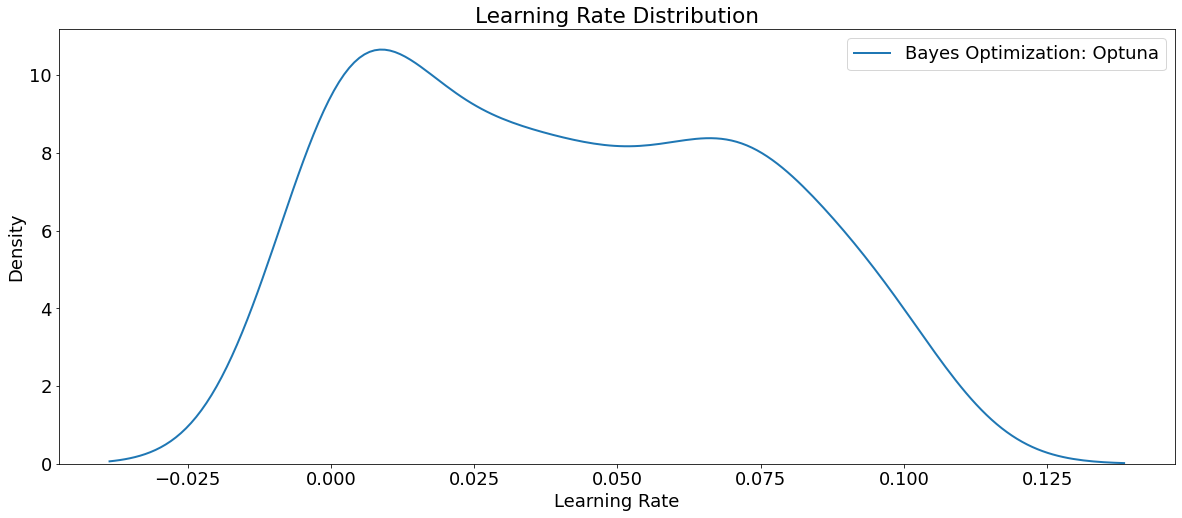

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18
sns.kdeplot(trials_df['learning_rate'], label = 'Bayes Optimization: Optuna', 
            linewidth = 2)
plt.legend(loc = 1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

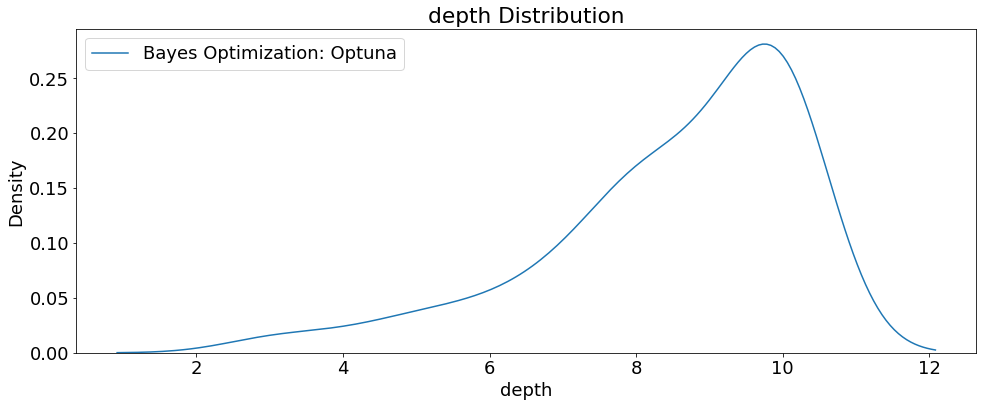

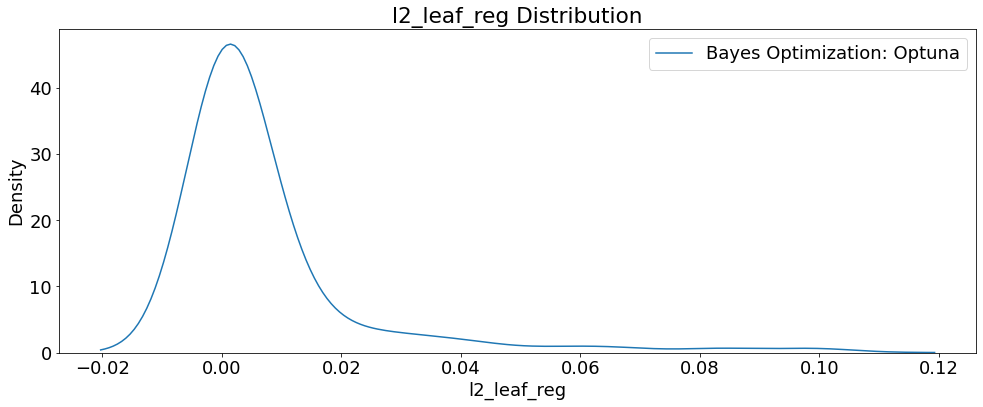

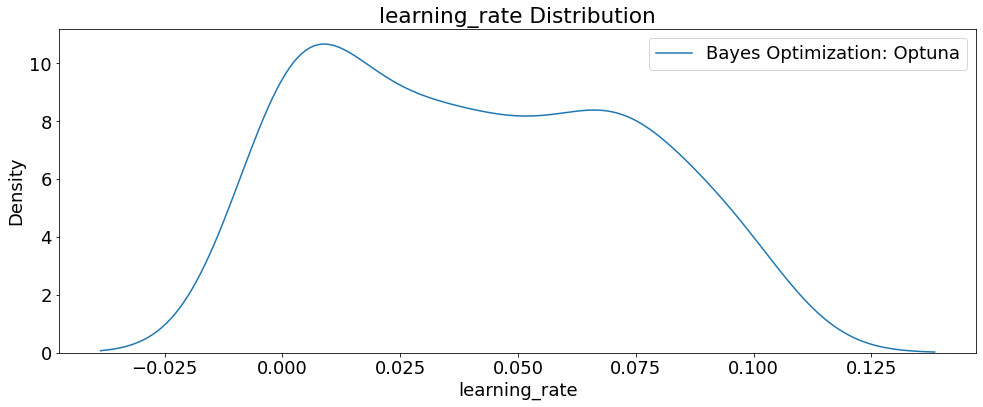

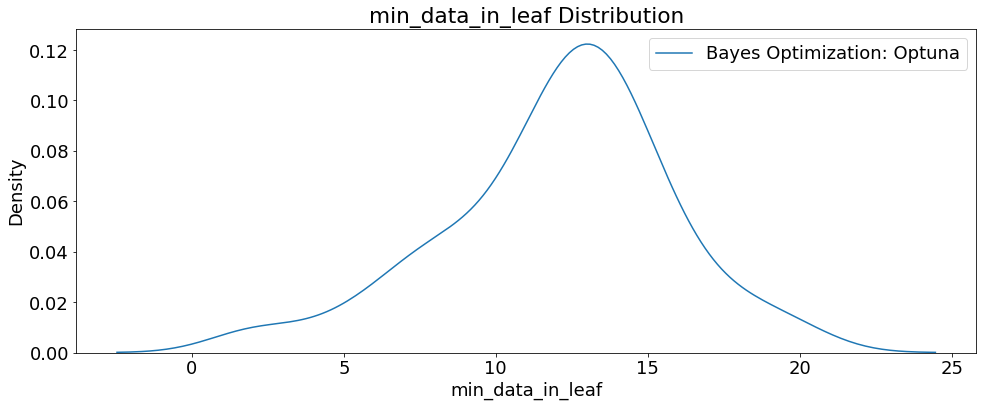

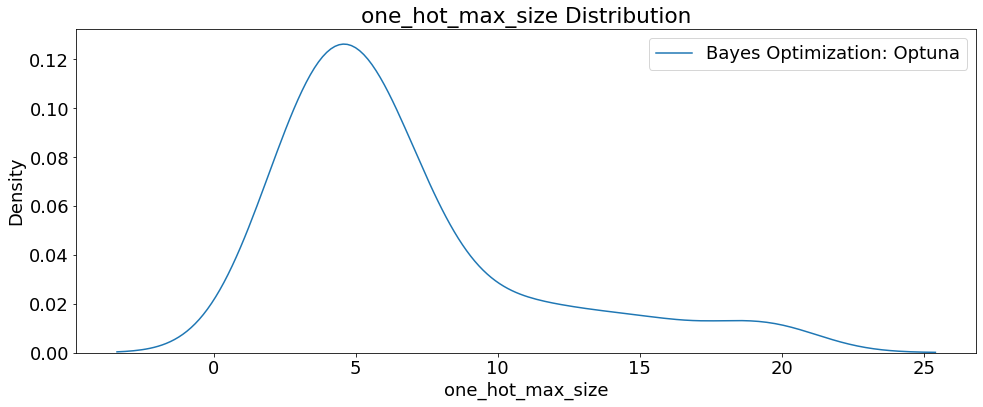

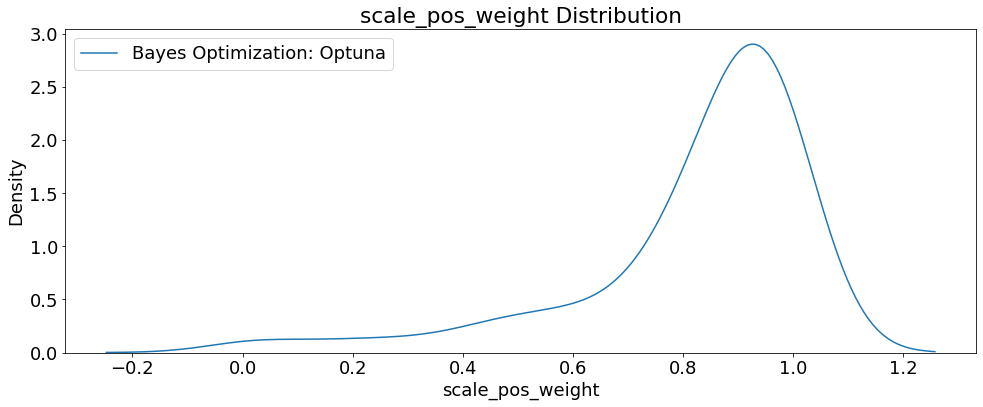

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'logloss', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label = 'Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



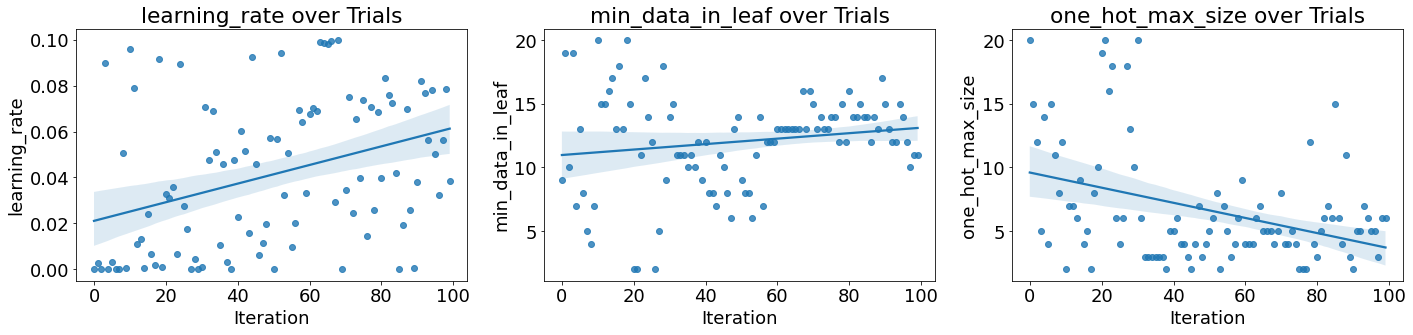

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 3, figsize = (20, 5))
i = 0
for i, hpo in enumerate(['learning_rate', 'min_data_in_leaf', 
                         'one_hot_max_size']):
        # Scatterplot
        sns.regplot('iteration', hpo, data = trials_df, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo), 
                   title = '{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



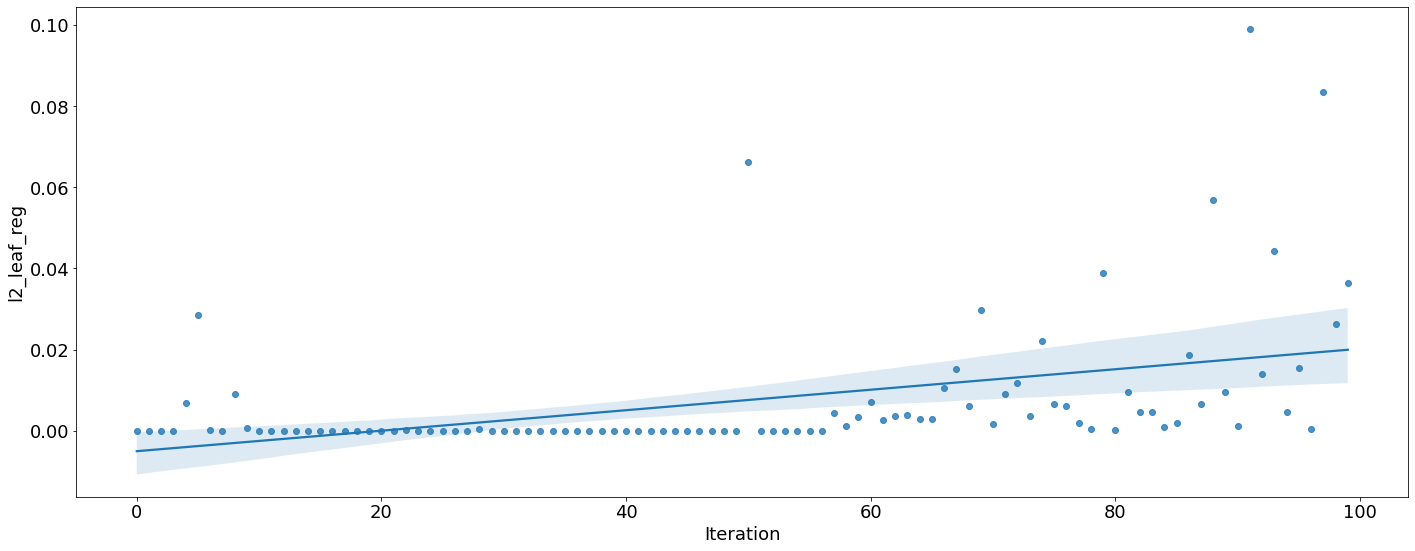

In [ ]:
# Scatterplot of regularization hyperparameters
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18
ax = sns.regplot('iteration', 'l2_leaf_reg', data = trials_df, label = 'Bayes Optimization') 
ax.set(xlabel = 'Iteration', ylabel = 'l2_leaf_reg')                 
plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_Catboost_Optuna_100_GPU_glove_sentPol.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_Catboost_Optuna_100_GPU_glove_sentPol.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params=study.best_params   
params['random_state'] = seed_value
params['loss_function']= 'Logloss'
params

{'depth': 9,
 'iterations': 400,
 'l2_leaf_reg': 0.026335488094232425,
 'learning_rate': 0.07836898903729032,
 'loss_function': 'Logloss',
 'min_data_in_leaf': 11,
 'one_hot_max_size': 6,
 'random_state': 42,
 'scale_pos_weight': 0.9793364716341348}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/SentimentPolarity/Model_PKL/


study = joblib.load('Catboost_Optuna_100_GPU_glove_sentPol.pkl')

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/SentimentPolarity/Model_PKL


In [ ]:
label = df[['sentiment']]

features = df.cleanReview

# Partition data for train/test 
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    test_size=0.2, stratify=label)

In [ ]:
# Vectorize reviews in train/test sets
X_train = pl.fit_transform(X_train)
X_test = pl.fit_transform(X_test)

In [ ]:
# Re-create the best model and train on the training data
best_model = CatBoostClassifier(early_stopping_rounds=100,
                               rsm=1, 
                               task_type='GPU', 
                               logging_level='Silent', 
                                **params)
# Fit the model
#.ravel()
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Catboost_HPO_Optuna_trials100_glove_GPU_sentPol.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Catboost_HPO_Optuna_trials100_glove_GPU_sentPol.pkl')
# print(model)
# =============================================================================

In [ ]:
print('Results from Catboost HPO Optuna 100 GloVe GPU Sentiment Polarity trials:')
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report: Train')
clf_rpt = classification_report(y_train, y_train_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Train')
print(confusion_matrix(y_train, y_train_pred))
print('\n')
print('Classification Report: Test')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Test')
print(confusion_matrix(y_test, y_test_pred))
print('\n')

print('Accuracy score: train: %.3f, test: %.3f' % (
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred)))
print('Precision score: train: %.3f, test: %.3f' % (
        precision_score(y_train, y_train_pred),
        precision_score(y_test, y_test_pred)))
print('Recall score: train: %.3f, test: %.3f' % (
        recall_score(y_train, y_train_pred),
        recall_score(y_test, y_test_pred)))
print('F1 score: train: %.3f, test: %.3f' % (
        f1_score(y_train, y_train_pred),
        f1_score(y_test, y_test_pred)))

Results from Catboost HPO Optuna 100 GloVe GPU Sentiment Polarity trials:


Classification Report: Train
              precision    recall  f1-score   support

           0       0.96      0.97      0.97    331949
           1       0.97      0.96      0.96    331950

    accuracy                           0.97    663899
   macro avg       0.97      0.97      0.97    663899
weighted avg       0.97      0.97      0.97    663899



Confusion matrix: Train
[[320963  10986]
 [ 12250 319700]]


Classification Report: Test
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     82988
           1       0.96      0.96      0.96     82987

    accuracy                           0.96    165975
   macro avg       0.96      0.96      0.96    165975
weighted avg       0.96      0.96      0.96    165975



Confusion matrix: Test
[[79674  3314]
 [ 3683 79304]]


Accuracy score: train: 0.965, test: 0.958
Precision score: train: 0.967, test: 0.960
Recall 

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/SentimentPolarity/trialOptions/

# Access results
trials_df = pd.read_csv('Catboost_Optuna_100_GPU_glove_sentPol.csv')

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/SentimentPolarity/trialOptions


In [ ]:
# Evaluate on the testing data 
print('The best model from optimization scores {:.5f} Accuracy on the test set.'.format(accuracy_score(y_test, y_test_pred)))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from optimization scores 0.95784 Accuracy on the test set.
This was achieved using these conditions:
iteration                                    98
logloss                                0.115018
datetime_start       2022-04-20 15:43:24.823675
datetime_complete    2022-04-20 15:44:46.147381
duration                 0 days 00:01:21.323706
depth                                         9
n_estimators                                400
l2_leaf_reg                            0.026335
learning_rate                          0.078369
min_data_in_leaf                             11
one_hot_max_size                              6
scale_pos_weight                       0.979336
state                                  COMPLETE
Name: 0, dtype: object
